In [14]:
# US Crime Dataset Analizi ve Suç Çözülebilirlik Tahmini
## Model: AdaBoost Classifier (Adaptive Boosting)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Sklearn Araçları
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, f1_score

warnings.filterwarnings('ignore')
print(">>> Gerekli kütüphaneler yüklendi.")

>>> Gerekli kütüphaneler yüklendi.


In [32]:
# Dosya Yolu
FILE_PATH = 'US_Crime_DataSet.csv'

def load_data(path):
    print(f"📂 Dosya okunuyor: {path}...")
    try:
        df = pd.read_csv(path, low_memory=False)
        print(f"✅ Veri Seti Yüklendi. Boyut: {df.shape}")
        return df
    except FileNotFoundError:
        print("❌ HATA: Dosya bulunamadı!")
        return None

df = load_data(FILE_PATH)
if df is not None:
    display(df.head())

📂 Dosya okunuyor: US_Crime_DataSet.csv...
✅ Veri Seti Yüklendi. Boyut: (638454, 24)


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [33]:
def clean_data(df):
    print(">>> 1. Aşama: Veri Temizliği Başlıyor...")
    
    # Gereksiz Sütunlar
    drop_cols = ['Record ID', 'Agency Code', 'Incident', 'Record Source',
                 'Victim Ethnicity', 'Victim Count', 'Perpetrator Ethnicity', 'Perpetrator Count',
                 'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Relationship']
    
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    # Hedef Değişken (Yes/No -> 1/0)
    if 'Crime Solved' in df.columns:
        df['Crime Solved'] = df['Crime Solved'].map({'Yes': 1, 'No': 0})
    
    # Yaş Sütunu Düzenleme
    df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce').fillna(30)
    
    print("✅ Temizlik Tamamlandı.")
    return df

if df is not None:
    df = clean_data(df)

>>> 1. Aşama: Veri Temizliği Başlıyor...
✅ Temizlik Tamamlandı.


In [34]:
def apply_feature_engineering(df):
    print(">>> 2. Aşama: Feature Engineering (Yeni Özellik Türetme)...")
    
    # 1. MEVSİM (SEASON)
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'
    df['Season'] = df['Month'].apply(get_season)
    print(f"- 'Season' özelliği oluşturuldu.")

    # 2. YAŞ GRUBU (AGE GROUP)
    bins = [0, 18, 29, 59, 120]
    labels = ['Child', 'Young_Adult', 'Adult', 'Senior']
    df['Age_Group'] = pd.cut(df['Victim Age'], bins=bins, labels=labels, right=True).astype(object).fillna('Unknown')
    print(f"- 'Age_Group' özelliği oluşturuldu.")

    # 3. BÖLGE (REGION)
    regions = {
        'West': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'AZ', 'NM', 'CO', 'AK', 'HI'],
        'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
        'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'DE', 'MD', 'DC'],
        'Northeast': ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
    }
    state_to_region = {state: region for region, states in regions.items() for state in states}
    df['Region'] = df['State'].map(state_to_region).fillna('Other')
    print(f"- 'Region' özelliği oluşturuldu.")
    
    return df

if df is not None:
    df = apply_feature_engineering(df)
    # Kontrol için göster
    display(df[['Season', 'Age_Group', 'Region']].head())

>>> 2. Aşama: Feature Engineering (Yeni Özellik Türetme)...
- 'Season' özelliği oluşturuldu.
- 'Age_Group' özelliği oluşturuldu.
- 'Region' özelliği oluşturuldu.


,Season,Age_Group,Region
0,Fall,Child,Other
1,Fall,Adult,Other
2,Fall,Adult,Other
3,Fall,Adult,Other
4,Fall,Adult,Other


In [35]:
def apply_encoding(df):
    print(">>> 3. Aşama: Encoding (Kategorik -> Sayısal)...")
    
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('Unknown')
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        
    print("✅ Kategorik veriler sayıya çevrildi.")
    return df

if df is not None:
    df_processed = apply_encoding(df)

>>> 3. Aşama: Encoding (Kategorik -> Sayısal)...
✅ Kategorik veriler sayıya çevrildi.


In [36]:
if df is not None:
    X = df_processed.drop('Crime Solved', axis=1)
    y = df_processed['Crime Solved']
    
    feature_names_original = list(X.columns)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    print(f"Veri Hazır! Eğitim Seti: {X_train_raw.shape}")

Veri Hazır! Eğitim Seti: (510763, 14)


In [37]:
def select_features_smart(X_train, y_train, X_test, feature_names):
    print(">>> En kritik özellikler seçiliyor (DecisionTree)...")
    
    selector = SelectFromModel(DecisionTreeClassifier(max_depth=10, random_state=42), max_features=10)
    selector.fit(X_train, y_train)
    
    selected_indices = selector.get_support(indices=True)
    selected_names = [feature_names[i] for i in selected_indices]
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
    
    print(f"✅ Seçilen Özellikler ({len(selected_names)} adet):")
    print(selected_names)
    
    return X_train_sel, X_test_sel, selected_names

X_train, X_test, final_feature_names = select_features_smart(
    X_train_raw, y_train, X_test_raw, feature_names_original
)

>>> En kritik özellikler seçiliyor (DecisionTree)...
✅ Seçilen Özellikler (5 adet):
['Agency Name', 'State', 'Year', 'Victim Age', 'Weapon']


In [38]:
print("🚀 AdaBoostClassifier Eğitiliyor...")
start_time = time.time()

# Model Parametreleri
# n_estimators=50: 50 düzeltme turu
model = AdaBoostClassifier(n_estimators=50, random_state=42)

model.fit(X_train, y_train)

elapsed = time.time() - start_time
print(f"✅ Eğitim Bitti! Süre: {elapsed:.2f} saniye")

🚀 AdaBoostClassifier Eğitiliyor...
✅ Eğitim Bitti! Süre: 12.54 saniye


In [39]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc = roc_auc_score(y_test, y_prob)

print("="*60)
print(f"SONUÇ: Accuracy: %{acc*100:.2f} | ROC AUC: {roc:.4f}")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Çözülemedi', 'Çözüldü']))

SONUÇ: Accuracy: %70.51 | ROC AUC: 0.6744
              precision    recall  f1-score   support

  Çözülemedi       0.54      0.04      0.07     37875
     Çözüldü       0.71      0.99      0.82     89816

    accuracy                           0.71    127691
   macro avg       0.63      0.51      0.45    127691
weighted avg       0.66      0.71      0.60    127691



In [40]:
def show_feature_importance_table(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_imp_df = pd.DataFrame({
            'Özellik': feature_names,
            'Önem Puanı': importances
        }).sort_values(by='Önem Puanı', ascending=False)
        
        feature_imp_df['Katkı (%)'] = (feature_imp_df['Önem Puanı'] * 100).map('{:.2f}%'.format)
        
        print("\n📊 ÖZELLİK ÖNEM TABLOSU")
        display(feature_imp_df)
    else:
        print("Özellik önemi bulunamadı.")

show_feature_importance_table(model, final_feature_names)


📊 ÖZELLİK ÖNEM TABLOSU


,Özellik,Önem Puanı,Katkı (%)
1,State,0.321870,32.19%
4,Weapon,0.275814,27.58%
3,Victim Age,0.274879,27.49%
0,Agency Name,0.117042,11.70%
2,Year,0.010395,1.04%


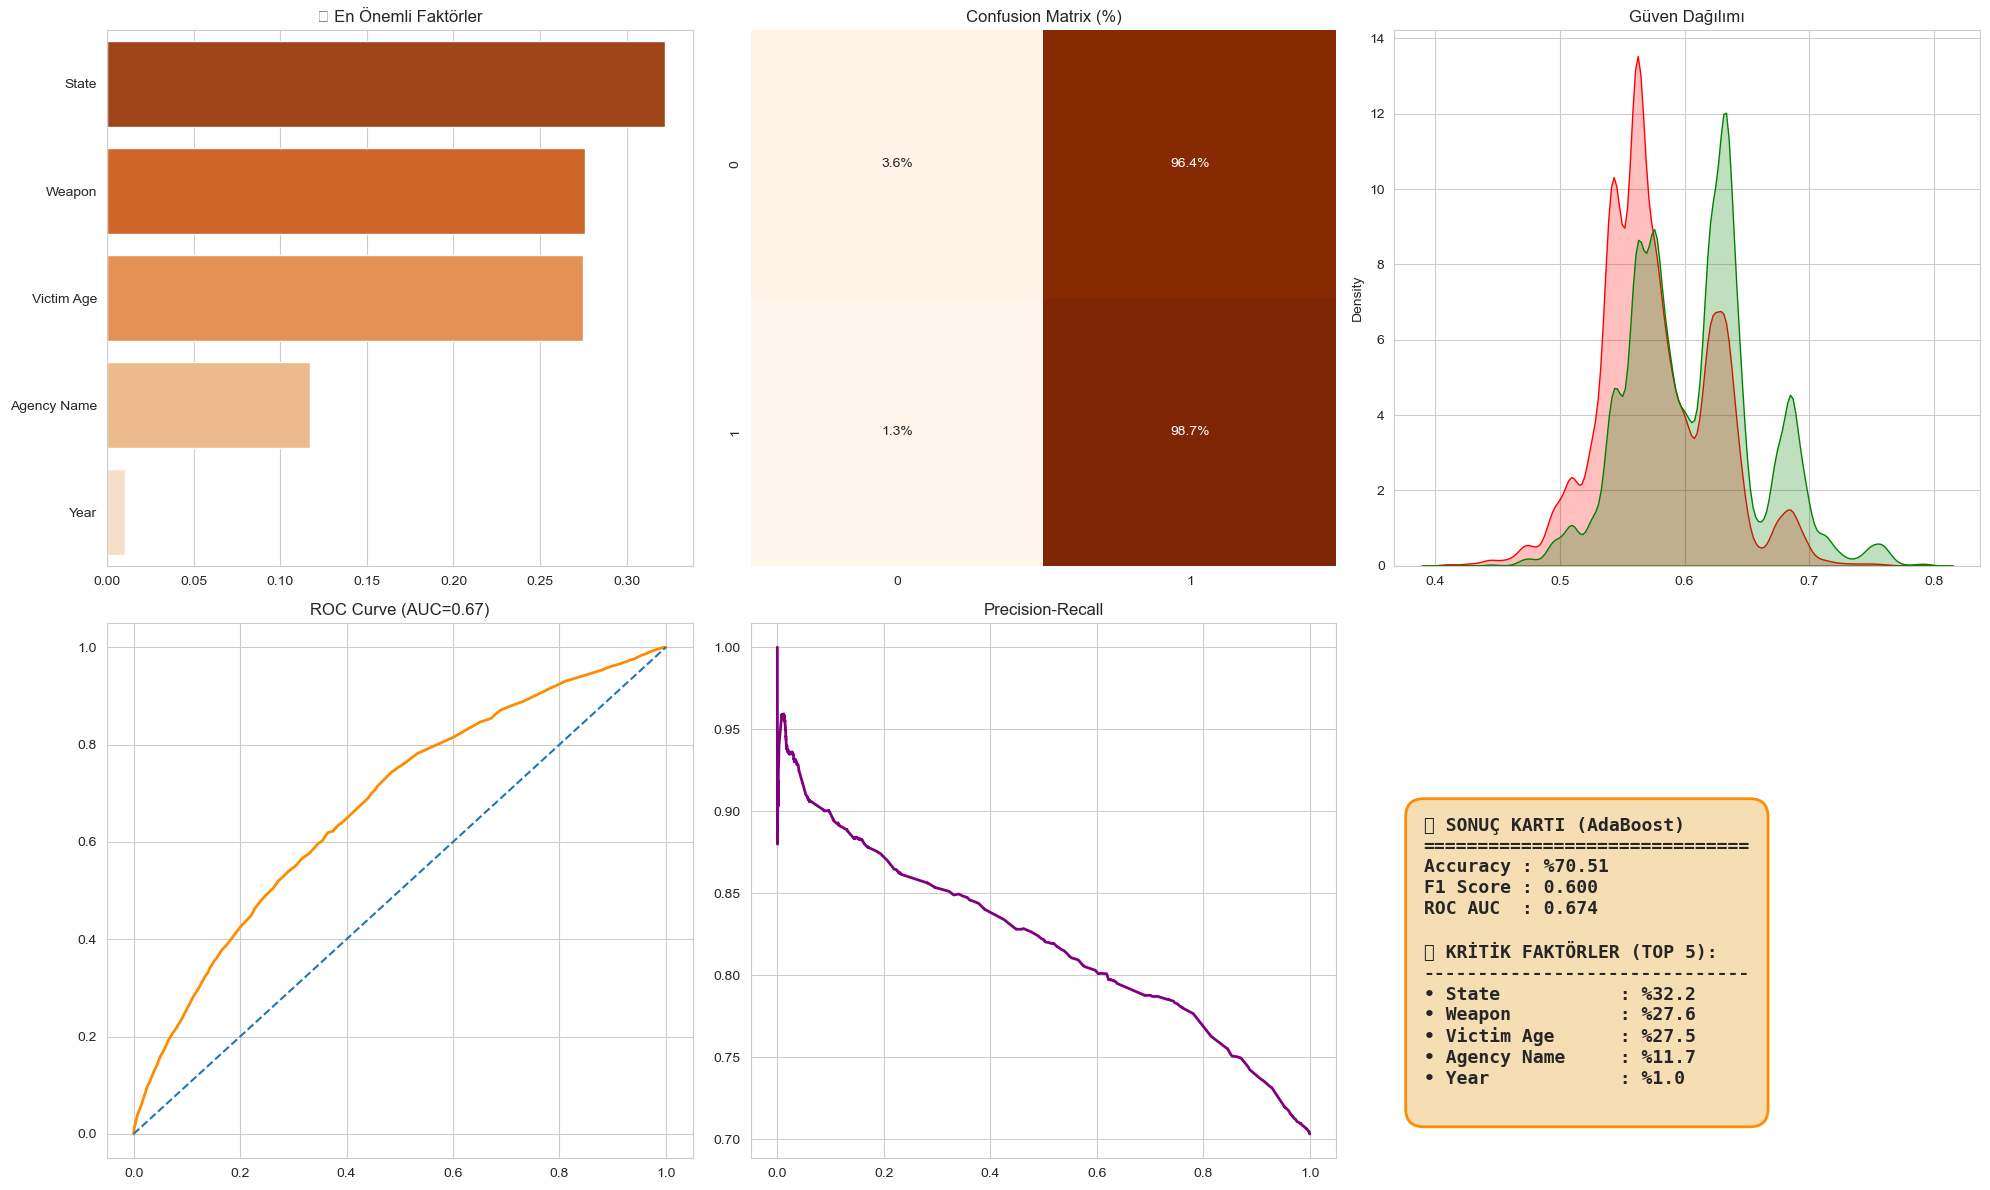

In [41]:
def plot_dashboard(model, X_test, y_test, feature_names, y_pred, y_prob):
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3)

    # 1. Feature Importance
    ax1 = fig.add_subplot(gs[0, 0])
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
        idx = np.argsort(imp)[::-1][:10]
        # AdaBoost için Turuncu (Oranges) palet
        sns.barplot(x=imp[idx], y=[feature_names[i] for i in idx], palette="Oranges_r", ax=ax1)
        ax1.set_title('🔍 En Önemli Faktörler')

    # 2. Confusion Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Oranges', cbar=False, ax=ax2)
    ax2.set_title('Confusion Matrix (%)')

    # 3. Güven Dağılımı
    ax3 = fig.add_subplot(gs[0, 2])
    sns.kdeplot(y_prob[y_test==0], shade=True, color='red', label='Çözülemedi', ax=ax3)
    sns.kdeplot(y_prob[y_test==1], shade=True, color='green', label='Çözüldü', ax=ax3)
    ax3.set_title('Güven Dağılımı')

    # 4. ROC
    ax4 = fig.add_subplot(gs[1, 0])
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax4.plot(fpr, tpr, color='darkorange', lw=2)
    ax4.plot([0, 1], [0, 1], linestyle='--')
    ax4.set_title(f'ROC Curve (AUC={roc_auc_score(y_test, y_prob):.2f})')

    # 5. Precision-Recall
    ax5 = fig.add_subplot(gs[1, 1])
    p, r, _ = precision_recall_curve(y_test, y_prob)
    ax5.plot(r, p, color='purple', lw=2)
    ax5.set_title('Precision-Recall')

    # 6. SONUÇ KARTI (GELİŞTİRİLMİŞ)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    # İstatistikler
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc = roc_auc_score(y_test, y_prob)
    
    # En İyi 5 Özellik Metni
    feature_text = ""
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
        idx = np.argsort(imp)[::-1][:5]
        feature_text += "\n📌 KRİTİK FAKTÖRLER (TOP 5):\n"
        feature_text += "-"*30 + "\n"
        for i in idx:
            feature_text += f"• {feature_names[i]:<15} : %{imp[i]*100:.1f}\n"
    
    txt = f"🏁 SONUÇ KARTI (AdaBoost)\n" \
          f"==============================\n" \
          f"Accuracy : %{acc*100:.2f}\n" \
          f"F1 Score : {f1:.3f}\n" \
          f"ROC AUC  : {roc:.3f}\n" \
          f"{feature_text}"
    
    # Turuncu Temaya Uygun Arkaplan (Wheat)
    ax6.text(0.05, 0.1, txt, fontsize=13, family='monospace', weight='bold', 
             bbox=dict(facecolor='wheat', alpha=1, boxstyle='round,pad=1', edgecolor='darkorange', linewidth=2))

    plt.tight_layout()
    plt.show()

plot_dashboard(model, X_test, y_test, final_feature_names, y_pred, y_prob)